# GAN TASK2

According to the hints, i make the following main adjustments based on my last task.
1. Change photo size from 28*28 to 32*32
2. Try 'deeper' DCGAN architecture
3. Implement correct WGAN-GP loss function and training process

## DCGAN Architecture

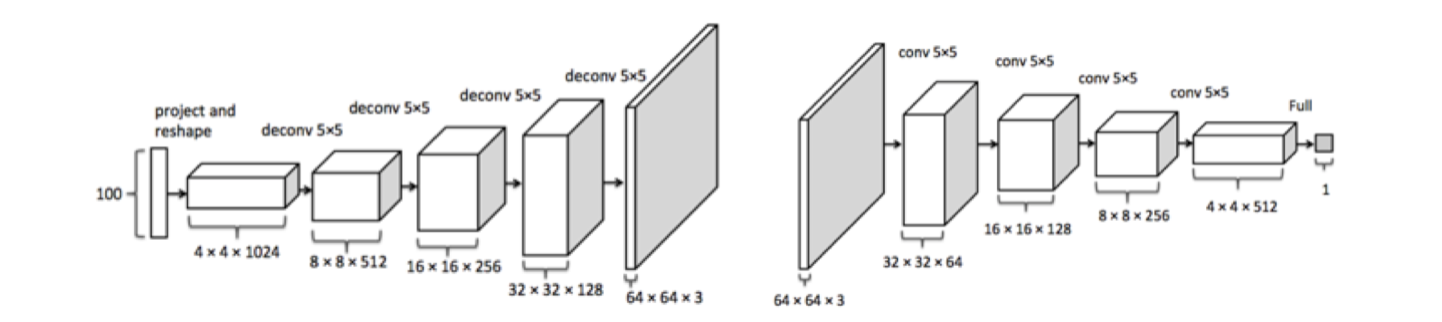

In [18]:
from IPython.display import Image
Image(filename='/Users/wangj3475/Programing/processing/fashion_gan/result/DCGAN_ARC.png') 

My understanding of DCGAN network architecture can be expressed as the plot above. 

For the generator, a 100 dimensional noise is projected to a small spatial extent convolutional representation with many feature maps. A series of four fractionally-strided convolutions then convert this high level representation into a image. 

For the discriminator, it's a inverse process by converting a image into a series higher level representations and  finally compressing the highest representations to a single element output.

The original network architecture i used in the last task is basically following the same logic:

For the generator, the representation (or say output of each layer) is: 
100 -> (7, 7, 256) -> (7, 7, 128) -> (14, 14, 64) -> (28, 28, 1)

For the discriminator, the representation (or say output of each layer) is:
(28, 28, 1) -> (14, 14, 64) -> (7, 7, 128) -> flattern -> 1

Notice that, to control the size of representation, in generator it's the strides of transposed convolution layer. Set strides to be 2 could double the size of representation. For discriminator, set the strides of convolution layer to be 2 would reduce half of the size of representation.

One 'constraint' for making the architecture deeper is the size of the image, which isn't convenient for unsampling. For instance, if the image is with size (64, 64), the representation would start from (4, 4), but for image with size of (28, 28), it would start from (7,7). (Making the architecture deeper is still workable for (28, 28) image, but in this case it can't upsample in each layer if there's more than 3 hidden layer). 

Similar idea for the discriminator.

Hence, one thing i did is to resize images from (28, 28) to (32, 32) so that i can apply deeper DCGAN architecture like:

for generator:

100 -> (4, 4, 256) -> (8, 8, 128) -> (16, 16, 64) -> (32, 32, 1)

or 

100 -> (4, 4, 512) -> (8, 8, 256) -> (16, 16, 128) -> (32, 32, 1)

for discriminator:

(32, 32, 1) -> (16, 16, 64) -> (8, 8, 128) -> (4, 4, 256) -> flattern -> 1

or 

(32, 32, 1) -> (16, 16, 64) -> (8, 8, 128) -> (4, 4, 256) -> (2, 2, 512) -> flattern -> 1

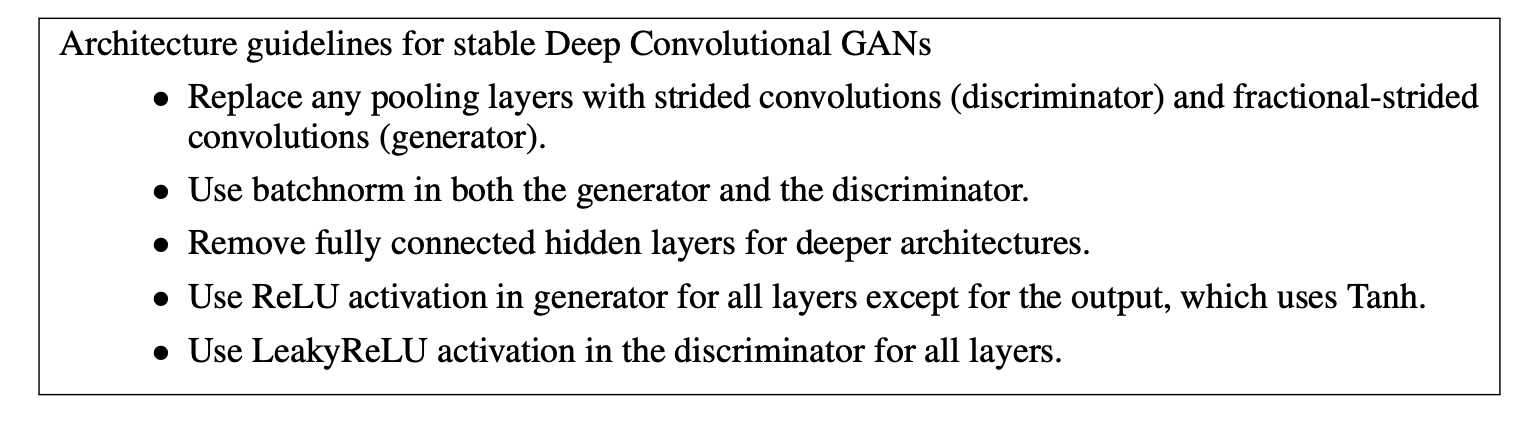

In [2]:
Image(filename='/Users/wangj3475/Programing/processing/fashion_gan/result/DCGAN_GUIDE.png') 

Based on the architecture guidelines of paper, in the last task,
1. Use batch normalization in both the generator and the discriminator
2. Use LeakyReLU activation in both the generator and the discriminator
3. Use Tanh in the last layer of the generator
4. Use sigmoid in the last layer of the discriminator

## WGAN-GP

### Issue exists in GAN
1. An optimal discriminator produces good information for the generator to improve. But if the generator is not doing a good job yet, the gradient for the generator diminishes and the generator learns nothing.
2. The original GAN paper proposes an alternative cost function to address this gradient vanishing problem. However, the functions have large variance of gradients that make the model unstable.
3. Need for adding noise to generated images to stabilize the model.


### How WGAN tries to solve the issue

1. Instead of adding noise, Wasserstein GAN (WGAN) proposes a new cost function using Wasserstein distance that has a smoother gradient everywhere. 
2. Use the fact that optimizing the discriminator easier than the generator. 
3. Drop the sigmoid function of discriminator and use it to learn 1-Lipschitz function needed for the calculation of calculate the Wasserstein distance.
4. WGAN applies a simple clipping to restrict the maximum weight value in 1-Lipschitz function

Different between GAN and WGAN are on loss function

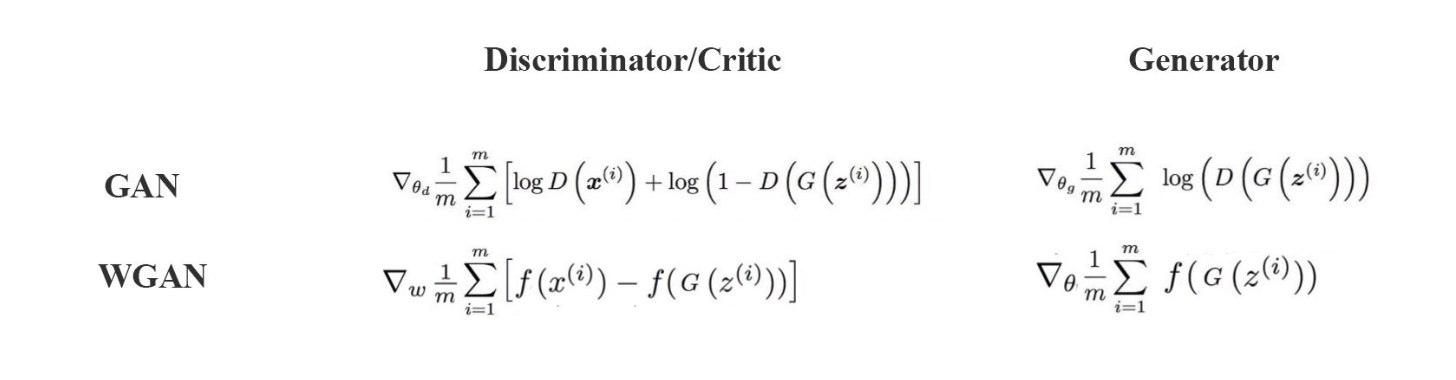

In [3]:
Image(filename='/Users/wangj3475/Programing/processing/fashion_gan/result/DIFF_WAGN1.png') 

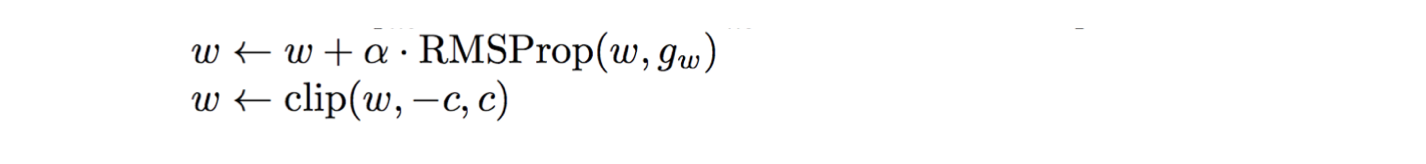

In [5]:
Image(filename='/Users/wangj3475/Programing/processing/fashion_gan/result/DIFF_WGAN2.png') 

### Issues exist in WGAN

The result of WGAN is sensitive to the hyperparameter of weight cliping. A slight change of c would lead to terrible performance.

### How WGAN-GP works

Given the fact that a differentiable function f is 1-Lipschitz if and only if it has gradients with norm at most 1 everywhere.

So instead of applying clipping, WGAN-GP penalizes the model if the gradient norm moves away from its target norm value 1. Moreover, it checks the gradient norm at the random point on line of real-fake.

The result is not sensitive to the parameter of loss function.

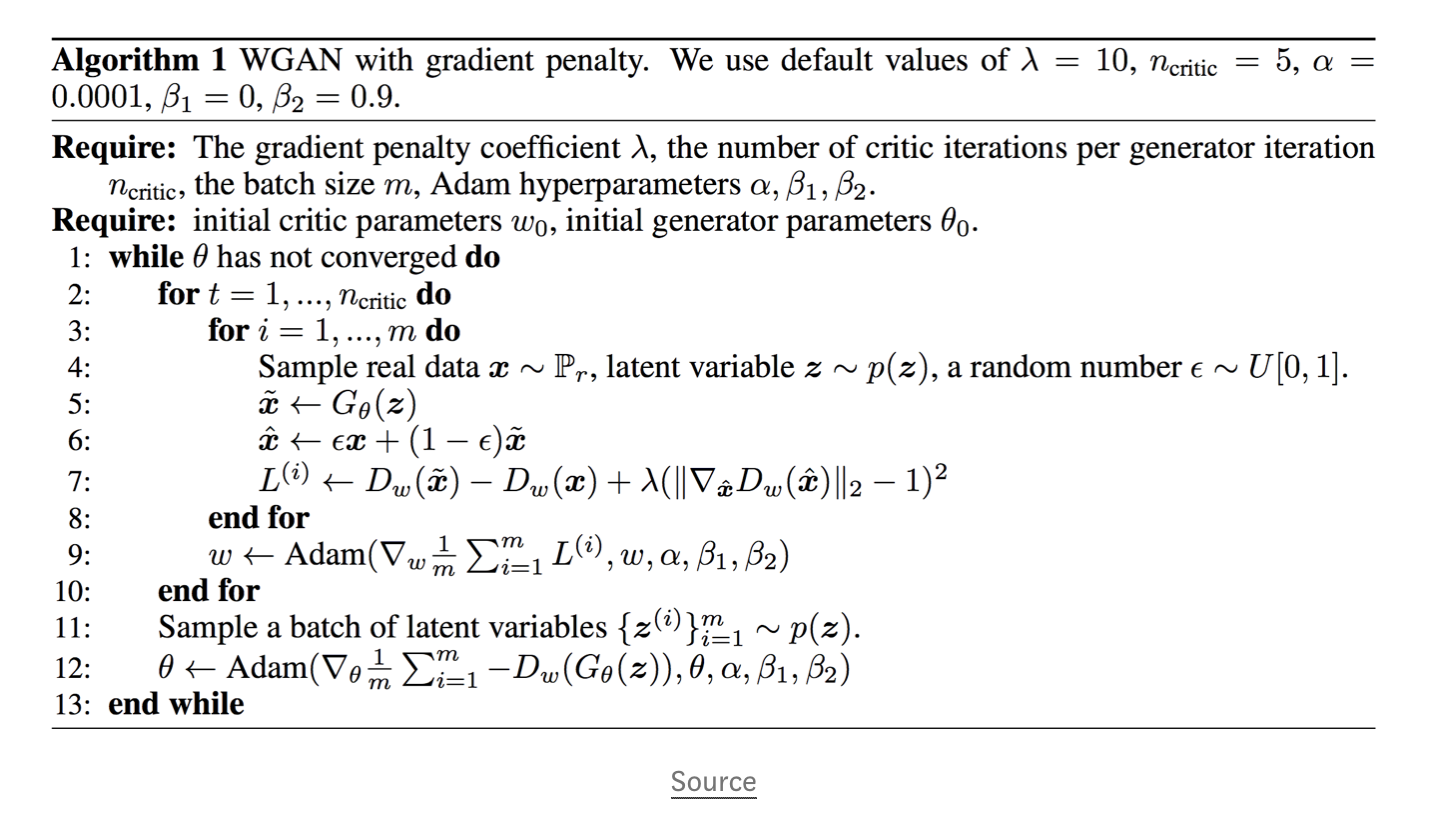

In [6]:
Image(filename='/Users/wangj3475/Programing/processing/fashion_gan/result/WGAN_GP_ALG.png') 

### The implementation of WGAN-GP

In last task, i add a gradient penalty to the original GAN function, which is wrong. By implementing the correct loss function for generator and discriminator as in the plot ablove, and also increasing the update frequency of discriminator per update of generator (in last task, i did the opposite thing as well ==), WGAN-GP is deployed with network architecture of DCGAN successfully.

The detailed setting of my GAN model:

Generator architecture: 100 -> (4, 4, 256) -> (8, 8, 128) -> (16, 16, 64) -> (32, 32, 1)

Discriminator architecture: (32, 32, 1) -> (16, 16, 64) -> (8, 8, 128) -> (4, 4, 256)-> flattern -> 1

Loss function: from WGAN-GP

n_critic: 3

AdamOptimizer: alpha = 2e-4, beta_1 = 0.5

epoch: 15

### Result

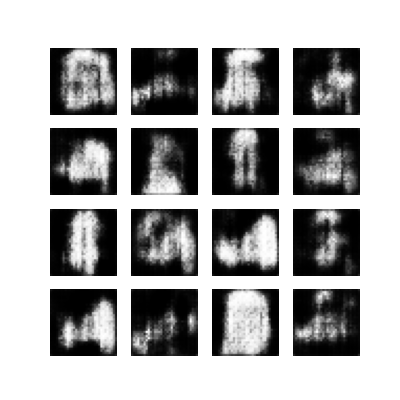

In [5]:
import IPython
import os
from IPython import display

anim_file = 'dcgan.gif'
test_num = 22
SAVE_PATH = '/Users/wangj3475/Programing/processing/fashion_gan/result/MINIST/res_{}'.format(test_num)

display.Image(filename=os.path.join(SAVE_PATH,anim_file))

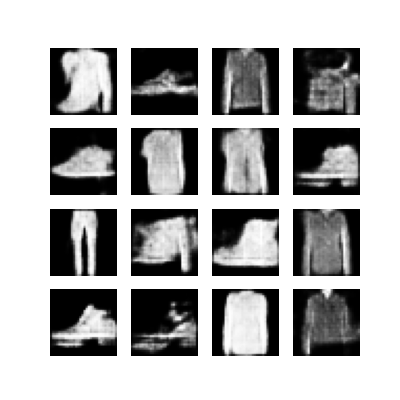

In [20]:
Image(filename='/Users/wangj3475/Programing/processing/fashion_gan/result/MINIST/res_22/image_at_epoch_0014.png') 

In [11]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline  
for i in range(14):
    temp = pd.read_csv(os.path.join(SAVE_PATH, 'loss_db_{}.csv'.format(i)))
    if i == 0:
        loss_db = temp
    else:
        loss_db = loss_db.append(temp)
loss_db.reset_index(drop=True, inplace=True)

In [12]:
# value of loss fucntion, check its learning process
G_loss = loss_db['G_Loss'] 
D_loss = loss_db['D_Loss']
# average value of classification result of real image and fake image
# check how the discrminator performans
D_real = loss_db['D_real']
D_fake = loss_db['D_fake']

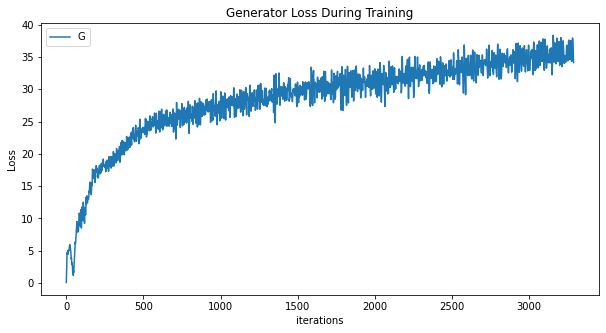

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator Loss During Training")
plt.plot(G_loss,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

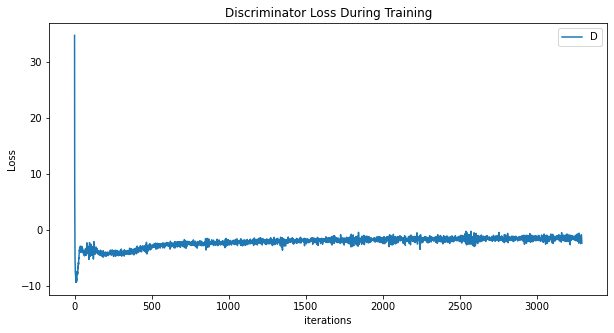

In [14]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(D_loss,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

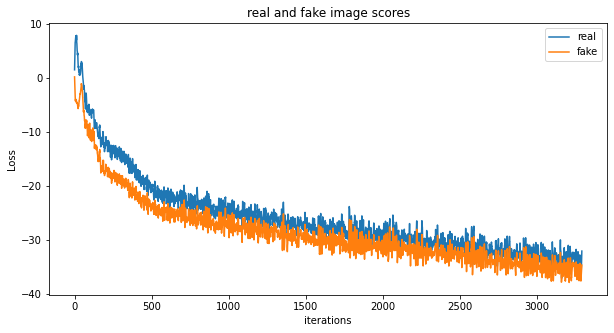

In [16]:
plt.figure(figsize=(10,5))
plt.title("real and fake image scores")
plt.plot(D_real,label="real")
plt.plot(D_fake,label="fake")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

The result looks better than the best of last task ! 

Future work:

1. Evaluate the quality of my GAN model besides check it by eyes. (there's method introduced in paper of DCGAN, haven't check it in details yet)
2. Add dropout ratio to generator (maybe it would try, worth try)
3. Take a look at BEGAN (it seems like BEGAN works better on fashion-mnist)